In [2]:
# importing libraries 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error







C:\Users\Jack Goodman\AppData\Local\Temp\ipykernel_18196\1200352119.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load the CSV data into a DataFrame
data = pd.read_csv('E:\COMP2002\insurance_dataset.csv')

In [4]:
data_encoded = pd.get_dummies(data, columns=['gender', 'smoker', 'region', 'medical_history', 'family_medical_history'])

for column in data_encoded.columns:
    if data_encoded[column].dtype == 'bool':
        data_encoded[column] = data_encoded[column].astype(int)

In [5]:
# Define the mapping for each column based on the given order.
ordinal_mappings = {
    'exercise_frequency': {'Never': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3},
    'occupation': {'Unemployed': 0, 'Student': 1, 'Blue collar': 2, 'White collar': 3},
    'coverage_level': {'Basic': 0, 'Standard': 1, 'Premium': 2}
}



for column, mapping in ordinal_mappings.items():
    data_encoded[column] = data_encoded[column].map(mapping)


In [6]:
target = data_encoded['charges']
features = data_encoded[['age', 'bmi', 'children', 'exercise_frequency', 'occupation',
       'coverage_level', 'charges', 'gender_female', 'gender_male',
       'smoker_no', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'medical_history_Diabetes',
       'medical_history_Heart disease', 'medical_history_High blood pressure',
       'family_medical_history_Diabetes',
       'family_medical_history_Heart disease',
       'family_medical_history_High blood pressure']]




In [7]:
print(data_encoded.dtypes)

age                                             int64
bmi                                           float64
children                                        int64
exercise_frequency                              int64
occupation                                      int64
coverage_level                                  int64
charges                                       float64
gender_female                                   int32
gender_male                                     int32
smoker_no                                       int32
smoker_yes                                      int32
region_northeast                                int32
region_northwest                                int32
region_southeast                                int32
region_southwest                                int32
medical_history_Diabetes                        int32
medical_history_Heart disease                   int32
medical_history_High blood pressure             int32
family_medical_history_Diabe

In [8]:

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

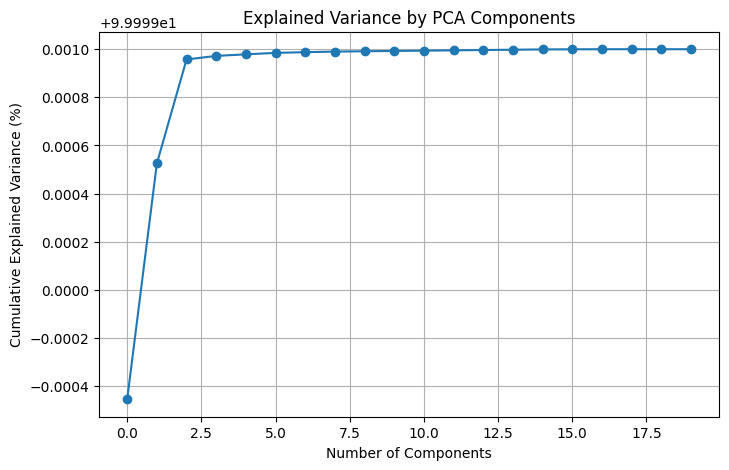

[ 99.99854454  99.99952507  99.99995736  99.99997224  99.99997864
  99.99998478  99.99998769  99.9999902   99.99999149  99.99999277
  99.99999405  99.99999533  99.99999661  99.99999789  99.99999917
  99.99999967  99.99999999 100.         100.         100.        ]


In [9]:
# Assuming 'inputs' is your pre-processed dataset (excluding the target variable)
pca = PCA().fit(features)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Optionally, print the cumulative explained variance
print(cumulative_explained_variance)

In [10]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA, choose the number of components based on your analysis
pca = PCA(n_components=2)  # for example, if you've decided to reduce to 2 dimensions

# Fit PCA on the scaled training data and transform both the training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Now, you can use X_train_pca and X_test_pca for training and evaluating your model

In [14]:
# Initialize and train the model
MLP = MLPRegressor(max_iter=1000)
MLP.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = MLP.predict(X_test_pca)

# Evaluate the predictions using mean squared error
mse_test = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse_test}")

# Perform cross-validation on the training set
MLP_cv_scores = cross_val_score(MLP, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate the average MSE from the cross-validation scores (taking absolute value since scores are negative)
MLP_cv_mse = abs(MLP_cv_scores.mean())
print(f"Cross-validation MSE: {MLP_cv_mse}")

Test MSE: 358621.6983331181
Cross-validation MSE: 533332.7212928061
